# Implementation of an Autoencoder (AE)
#### based on PyTorch tutorial https://pytorch.org/tutorials/beginner/basics/intro.html , https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html and https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb
## Simple linear AE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

###### ***For sc-RNAseq:*** fix enable cuda/GPU (only needed if CPU is to slow), try different optimiser, check for loss function, trying learning rates, nn.ReLU() function may not be the best, checking for overfitting by plotting loss of model and training data, Batch size has to be optimised: https://arxiv.org/abs/1609.04836 , https://arxiv.org/abs/1703.04933 . Maybe we should try a program like https://opendatascience.com/optimizing-pytorch-performance-batch-size-with-pytorch-profiler/ for that on a later stage for performance (not sure if the data will be to large in the future)

In [1]:
#import os
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
batch_size = 64

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####
dim_encoder_decoder = 28 * 28

class linear_AE(nn.Module):
    def __init__(self):
        super(linear_AE, self).__init__()

        self.encoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, 256),  #### data into the neural network layer (28*28 pixel -> 256 nodes)
            nn.ReLU(),                            #### ReLU(x) = (x)^(+) = max(0,x) 
            nn.Linear(256, 12)
        )
        
        self.decoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(12, 256),                   #### decoding laten layer (12 -> 256 nodes)
            nn.ReLU(),      #### 
            nn.Linear(256, dim_encoder_decoder),  #### reconstruction of image (256 -> 748)
            nn.Sigmoid()
        )
        
    def forward(self, x):                         # exicute the endcoder and decoder defined in __init__(self)
        
        endoded = self.encoder(x) 
        decoded = self.decoder(endoded) 
        return decoded
    
class encoder_Lin(nn.Module):
    def __init__(self):
        super(encoder_Lin, self).__init__()

        self.encoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, 256),  #### data into the neural network layer (28*28 pixel -> 256 nodes)
            nn.ReLU(),                            #### ReLU(x) = (x)^(+) = max(0,x) 
            nn.Linear(256, 12)
        )
        
    def forward(self, x):                         # exicute the endcoder and decoder defined in __init__(self)
        
        endoded = self.encoder(x) 
        
        return endoded

class decoder_Lin(nn.Module):
    def __init__(self):
        super(decoder_Lin, self).__init__()
        
        self.decoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(12, 256),                   #### decoding laten layer (12 -> 256 nodes)
            nn.ReLU(),      #### 
            nn.Linear(256, dim_encoder_decoder),  #### reconstruction of image (256 -> 748)
            nn.Sigmoid()
        )
        
    def forward(self, x):                         # exicute the endcoder and decoder defined in __init__(self)
        
        decoded = self.decoder(x) 
        
        return decoded
    
model_encoder = encoder_Lin().to(device)
model_decoder = decoder_Lin().to(device)

model = linear_AE().to(device) #### this is needed for cuda
print(model)

linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
loss_fn = nn.MSELoss() ###   .CrossEntropyLoss() #           ### nn.MSELoss() (Mean Square Error) for regression tasks

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)

Epoch:1, Loss:30.5305 ; Train Loss:19.0830
Epoch:2, Loss:17.9331 ; Train Loss:16.9042
Epoch:3, Loss:16.4993 ; Train Loss:15.9546
Epoch:4, Loss:15.7386 ; Train Loss:15.3551
Epoch:5, Loss:15.2381 ; Train Loss:15.0501
Epoch:6, Loss:14.8874 ; Train Loss:14.6481
Epoch:7, Loss:14.6094 ; Train Loss:14.3646
Epoch:8, Loss:14.3898 ; Train Loss:14.1474
Epoch:9, Loss:14.2216 ; Train Loss:13.9517
Epoch:10, Loss:14.0666 ; Train Loss:13.9671


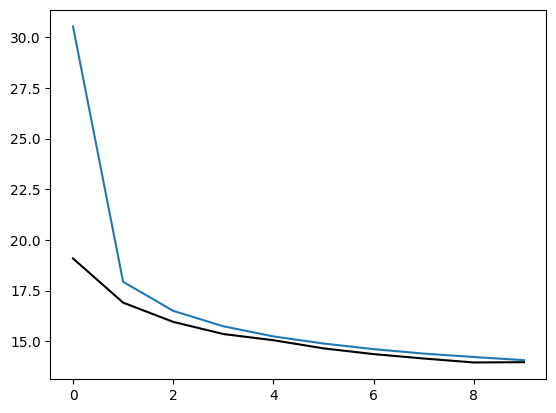

sec:  109.92138242721558
min:  1.8320230404535929
h:  0.030533717340893215


In [6]:
import time
start = time.time()


num_epochs = 10
outputs = []
outputs_test = []
torch.manual_seed(42)
for epoch in range(num_epochs):
    loss_total = 0
    for (X, label) in train_dataloader:
        X = X.reshape(-1, 28*28).to(device)
        pred = model(X)
        loss = loss_fn(pred,X)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f'Epoch:{epoch+1}, Loss:{loss_total:.4f}', end="")
    outputs.append([epoch, loss_total])
    
    loss_test_total = 0
    for (X_test, label) in test_dataloader:
        X_test = X_test.reshape(-1, 28*28).to(device)
        pred_test = model(X_test)
        loss_test = loss_fn(pred_test, X_test)
        
        loss_test_total += loss_test.item()
        
    print(f' ; Train Loss:{loss_test_total:.4f}')
    outputs_test.append([epoch, loss_test_total])
    #plt.scatter(epoch, loss_test_total, c="black")
plt.plot([i[0] for i in outputs_test], [i[1] for i in outputs_test],c="black")
plt.plot([i[0] for i in outputs], [i[1] for i in outputs])
plt.show()


end = time.time()
print("sec: ", end - start)
print("min: ", (end - start)/60)
print("h: ", (end - start)/60/60)

5 epochs:

    CPU:

    sec:  68.08382749557495
    min:  1.1347304582595825
    h:  0.018912174304326377

    GPU:  

    sec:  55.43866801261902
    min:  0.923977800210317
    h:  0.015399630003505282

10 epochs:

    CPU:

    sec:  132.21002578735352
    min:  2.203500429789225
    h:  0.03672500716315375

    GPU
    
    sec:  106.07081055641174
    min:  1.7678468426068623
    h:  0.029464114043447707
    
200 epochs:

    GPU
    
    sec:  2132.656932592392
    min:  35.5442822098732
    h:  0.5924047034978867


Epoch:1, Loss:30.4856 ; Train Loss:19.3102
Epoch:2, Loss:18.1017 ; Train Loss:17.0459
Epoch:3, Loss:16.5622 ; Train Loss:16.0014
Epoch:4, Loss:15.7717 ; Train Loss:15.3710
Epoch:5, Loss:15.2349 ; Train Loss:14.9644
Epoch:6, Loss:14.8617 ; Train Loss:14.6609
Epoch:7, Loss:14.5721 ; Train Loss:14.3192
Epoch:8, Loss:14.3534 ; Train Loss:14.2355
Epoch:9, Loss:14.1797 ; Train Loss:13.8956
Epoch:10, Loss:14.0293 ; Train Loss:13.8365


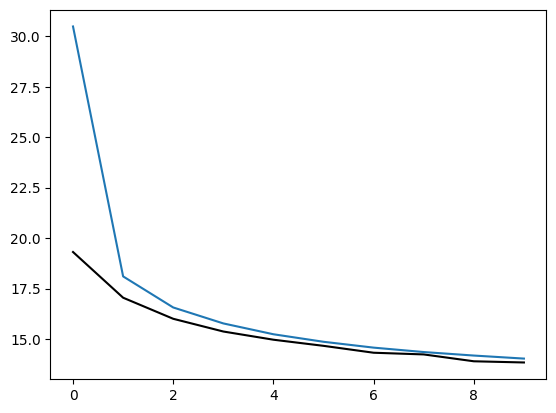

sec:  110.85749983787537
min:  1.8476249972979228
h:  0.03079374995496538


In [7]:
import time
start = time.time()

params_to_optimize = [
    {'params': model_encoder.parameters()},
    {'params': model_decoder.parameters()}
]

optimizer = torch.optim.Adam(params_to_optimize ,lr=1e-3, weight_decay=1e-5)

torch.manual_seed(42)
num_epochs = 10
outputs = []
outputs_test = []
torch.manual_seed(42)
for epoch in range(num_epochs):
    loss_total = 0
    for (X, label) in train_dataloader:
        X = X.reshape(-1, 28*28).to(device)
        pred = model_decoder(model_encoder(X))
        loss = loss_fn(pred,X)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f'Epoch:{epoch+1}, Loss:{loss_total:.4f}', end="")
    outputs.append([epoch, loss_total])
    
    loss_test_total = 0
    for (X_test, label) in test_dataloader:
        X_test = X_test.reshape(-1, 28*28).to(device)
        pred_test = model_decoder(model_encoder(X_test))
        loss_test = loss_fn(pred_test, X_test)
        
        loss_test_total += loss_test.item()
        
    print(f' ; Train Loss:{loss_test_total:.4f}')
    outputs_test.append([epoch, loss_test_total])
    #plt.scatter(epoch, loss_test_total, c="black")
plt.plot([i[0] for i in outputs_test], [i[1] for i in outputs_test],c="black")
plt.plot([i[0] for i in outputs], [i[1] for i in outputs])
plt.show()


end = time.time()
print("sec: ", end - start)
print("min: ", (end - start)/60)
print("h: ", (end - start)/60/60)

In [8]:
from tqdm import tqdm
import pandas as pd
encoded_samples = []
for sample in tqdm(mnist_data):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    label = sample[1]
    # Encode image
    model_encoder.eval()
    with torch.no_grad():
        encoded_img  = model_encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 60000/60000 [00:20<00:00, 2933.03it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            -4.749051        -5.539765         2.894431        12.804238   
1            -8.053926        -5.109262         0.284814        -1.735907   
2             0.461551         5.896713        -3.441353        -8.620998   
3            -1.413691         5.054708         1.771012         2.627272   
4            -6.973794         5.515500        -3.595503         6.697170   
...                ...              ...              ...              ...   
59995        -3.782674         5.426817        -4.105541         1.243918   
59996         0.475703         7.538086         1.342961         1.663712   
59997        -7.765813        -5.337760         4.593719         2.184157   
59998        -5.254583        -4.574133         1.091429        -5.687768   
59999       -10.463594         1.369752        -1.461180         1.920710   

       Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0             7.798503         7.398898         4.394256         5.709385   
1             7.560065       -12.467278        13.970436         0.990865   
2            -3.571250        -1.164621        -3.854685        -6.742873   
3             9.435384         6.052779        -2.961200        -2.919562   
4             2.059851        -7.582821       -13.862730       -15.134709   
...                ...              ...              ...              ...   
59995        -0.743456         6.285652         0.944004        -6.415964   
59996         8.067717         7.930110         2.061377        -0.844878   
59997        -1.515215         4.959414        -0.117337        -5.045005   
59998        12.007429        -9.563056         3.940085        -3.977810   
59999         0.141114        -2.549268         5.490477        -3.449449   

       Enc. Variable 8  Enc. Variable 9  Enc. Variable 10  Enc. Variable 11  \
0            -8.422103        11.039886        -12.760916         -3.374862   
1            -6.559906         1.015025        -14.831871          5.096598   
2            -1.464710        -6.696556         -8.861462         -6.561211   
3            -5.774930        12.230071          9.267113         -3.283648   
4             2.716984         4.640552         -3.411605         -5.167068   
...                ...              ...               ...               ...   
59995       -15.508129        15.043921         -9.338649         -0.542038   
59996       -16.947334         7.257857        -19.229757          0.080814   
59997        -2.491560        13.875710        -16.356974         -5.015021   
59998        -3.849910         1.857528         -1.731187          7.699805   
59999        -8.168409         8.376071          3.563209          1.331596   

       label  
0          5  
1          0  
2          4  
3          1  
4          9  
...      ...  
59995      8  
59996      3  
59997      5  
59998      6  
59999      8  

[60000 rows x 13 columns]

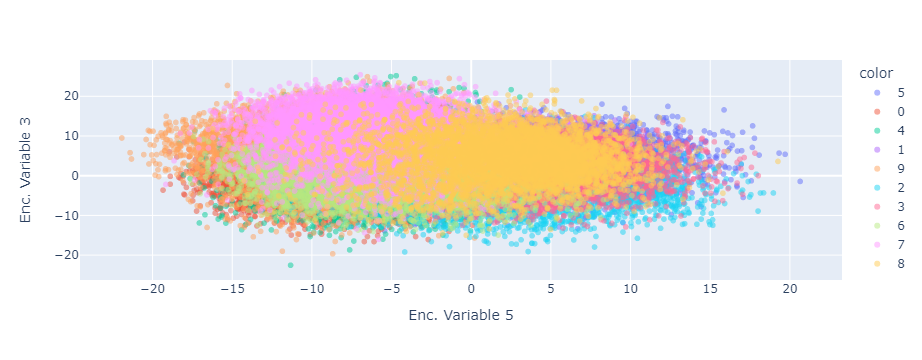

In [21]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 5', y='Enc. Variable 3', 
           color=encoded_samples.label.astype(str), opacity=0.5)

In [10]:
torch.save(model, 'model_oneLayer_AE.pth')

In [11]:
torch.save(model_encoder, 'model_encoder_oneLayer_AE.pth')
torch.save(model_decoder, 'model_decoder_oneLayer_AE.pth')